**Drive mount**

In [ ]:

import pandas as pd

from google.colab import drive
import os


drive.mount('/content/drive')

csv_file = '/content/drive/MyDrive/train.csv'
df = pd.read_csv(csv_file)


Mounted at /content/drive


**image load**

In [ ]:
import cv2
import numpy as np
import pandas as pd



data = []


for index, row in df.iterrows():
    filename = row['Filename']
    class_label = row['Label']

    image_path = '/content/drive/MyDrive/train/' + filename

    image = cv2.imread(image_path)


    if image is not None:
        #image = cv2.resize(image, (224, 224))
        data.append((image, class_label))


data = np.array(data, dtype=object)


X = np.array(data[:, 0].tolist())
y = np.array(data[:, 1])

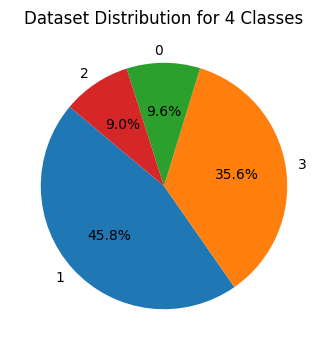

In [ ]:
import matplotlib.pyplot as plt


class_counts = pd.Series(y).value_counts()


plt.figure(figsize=(6, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution for 4 Classes')
plt.show()


**one hot encoding**

In [ ]:

from sklearn.preprocessing import OneHotEncoder




encoder = OneHotEncoder(sparse=False)


Y= encoder.fit_transform(y.reshape(-1, 1))


Y.shape


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(7560, 4)

In [ ]:
Y.shape


(7560, 4)

**dataset split 70 15 15**

In [ ]:
from sklearn.model_selection import train_test_split




X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)


X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (5292, 100, 100, 3)
Y_train shape: (5292, 4)
X_val shape: (1134, 100, 100, 3)
Y_val shape: (1134, 4)
X_test shape: (1134, 100, 100, 3)
Y_test shape: (1134, 4)


**densenet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping


base_model = DenseNet121(weights='imagenet', include_top=False)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers[-10:]:
    layer.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)


history_fine_tuning = model.fit(X_train, Y_train,
                                validation_data=(X_val, Y_val),
                                epochs=10,
                                batch_size=32,
                                callbacks=[early_stopping])


29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/10
166/166 [==============================] - 105s 181ms/step - loss: 0.5229 - accuracy: 0.8141 - val_loss: 0.3522 - val_accuracy: 0.8845
Epoch 2/10
166/166 [==============================] - 20s 118ms/step - loss: 0.1394 - accuracy: 0.9501 - val_loss: 0.2034 - val_accuracy: 0.9339
Epoch 3/10
166/166 [==============================] - 19s 112ms/step - loss: 0.0659 - accuracy: 0.9788 - val_loss: 0.2403 - val_accuracy: 0.9189
Epoch 4/10
166/166 [==============================] - 19s 117ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.1833 - val_accuracy: 0.9471
Epoch 5/10
166/166 [==============================] - 19s 113ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.1628 - val_accuracy: 0.9612
Epoch 6/10
166/166 [==============================] - 20s 120ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.1681 - val_accuracy: 0.9577
Epoch 7/10
166/166 [==============================] - 19s 113ms/

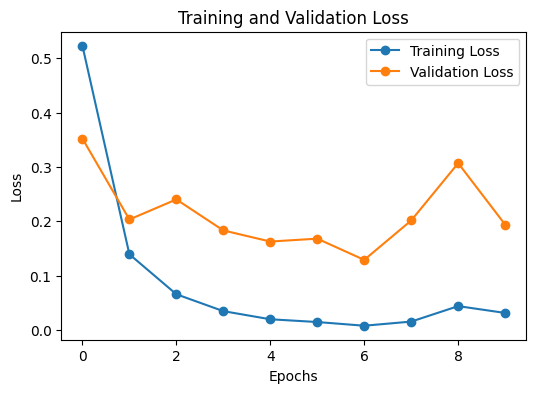

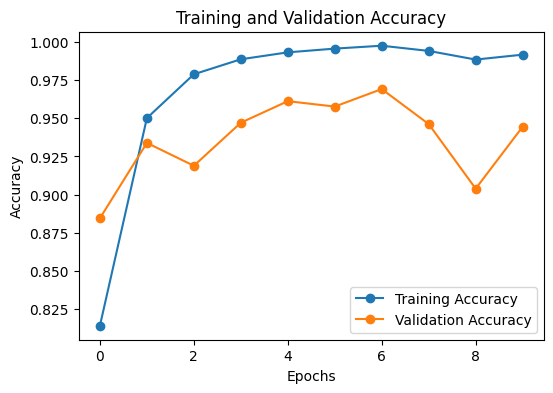

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history_fine_tuning.history['loss'], label='Training Loss',marker='o')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




36/36 [==============================] - 1s 33ms/step - loss: 0.1640 - accuracy: 0.9586
Test Loss: 0.16402357816696167
Test Accuracy: 0.9585537910461426
36/36 [==============================] - 4s 25ms/step
Precision: 0.9593581638554297
Recall: 0.9585537918871252
F1-score: 0.9587211041824136


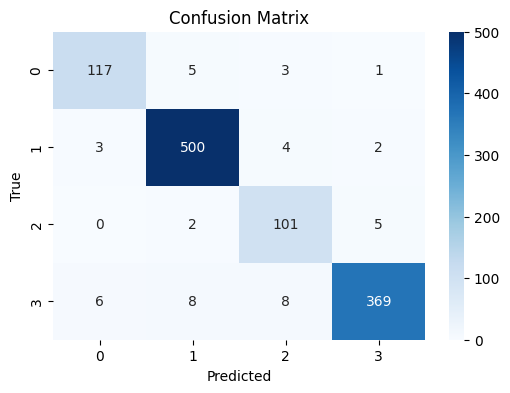

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Y_pred = model.predict(X_test)
Y_pred_classes_dense = np.argmax(Y_pred, axis=1)


Y_test_classes = np.argmax(Y_test, axis=1)


precision = precision_score(Y_test_classes, Y_pred_classes_dense, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes_dense, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes_dense, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**custom**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(4, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train,
                                validation_data=(X_val, Y_val),
                                epochs=20,
                                batch_size=32,
                                callbacks=[early_stopping])

Epoch 1/20
166/166 [==============================] - 6s 20ms/step - loss: 5.6114 - accuracy: 0.6927 - val_loss: 0.5910 - val_accuracy: 0.7734
Epoch 2/20
166/166 [==============================] - 2s 12ms/step - loss: 0.5267 - accuracy: 0.8090 - val_loss: 0.6667 - val_accuracy: 0.7778
Epoch 3/20
166/166 [==============================] - 2s 12ms/step - loss: 0.4592 - accuracy: 0.8331 - val_loss: 0.4959 - val_accuracy: 0.8183
Epoch 4/20
166/166 [==============================] - 2s 12ms/step - loss: 0.3874 - accuracy: 0.8641 - val_loss: 0.5461 - val_accuracy: 0.8042
Epoch 5/20
166/166 [==============================] - 2s 12ms/step - loss: 0.3258 - accuracy: 0.8779 - val_loss: 0.4574 - val_accuracy: 0.8457
Epoch 6/20
166/166 [==============================] - 2s 14ms/step - loss: 0.2499 - accuracy: 0.9129 - val_loss: 0.6848 - val_accuracy: 0.8245
Epoch 7/20
166/166 [==============================] - 2s 14ms/step - loss: 0.2117 - accuracy: 0.9267 - val_loss: 0.4930 - val_accuracy: 0.8492

In [ ]:
from tensorflow.keras.models import load_model, save_model
model.save('custom.h5')


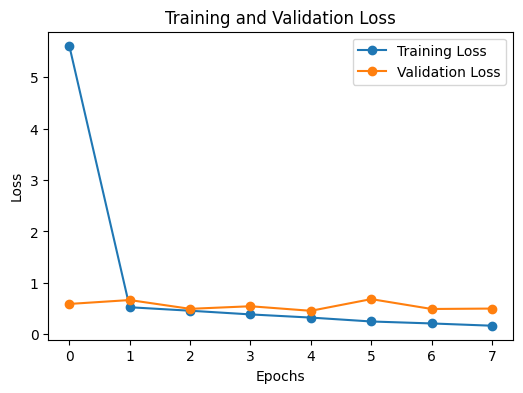

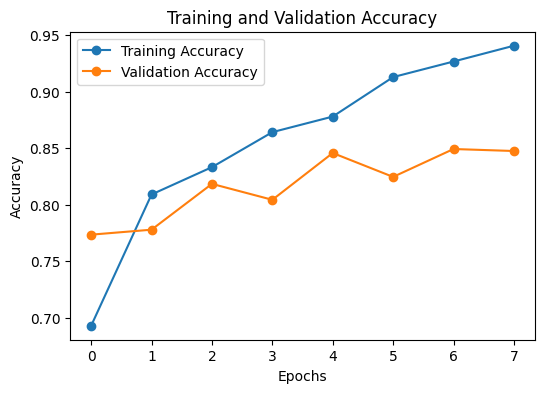

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




36/36 [==============================] - 0s 6ms/step - loss: 0.5046 - accuracy: 0.8492
Test Loss: 0.5046411752700806
Test Accuracy: 0.8492063283920288
36/36 [==============================] - 0s 4ms/step
Precision: 0.8436077952955187
Recall: 0.8492063492063492
F1-score: 0.8453104593773456


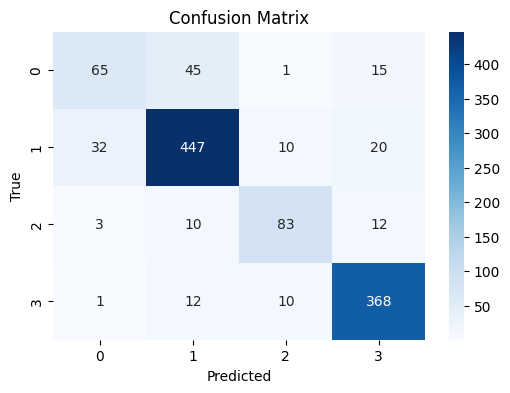

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Y_pred = model.predict(X_test)
Y_pred_classes_custom = np.argmax(Y_pred, axis=1)


Y_test_classes = np.argmax(Y_test, axis=1)


precision = precision_score(Y_test_classes, Y_pred_classes_custom, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes_custom, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes_custom, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_custom)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**resnet50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the custom model
model = Model(inputs=base_model.input, outputs=predictions)


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


#model_checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)




for layer in base_model.layers[-10:]:
    layer.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
history = model.fit(X_train, Y_train,
                                validation_data=(X_val, Y_val),
                                epochs=10,
                                batch_size=32,
                                callbacks=[early_stopping])

Epoch 1/10
166/166 [==============================] - 8s 46ms/step - loss: 0.0965 - accuracy: 0.9652 - val_loss: 0.6100 - val_accuracy: 0.8810
Epoch 2/10
166/166 [==============================] - 8s 46ms/step - loss: 0.0819 - accuracy: 0.9707 - val_loss: 0.3308 - val_accuracy: 0.9180
Epoch 3/10
166/166 [==============================] - 7s 44ms/step - loss: 0.0535 - accuracy: 0.9822 - val_loss: 0.2773 - val_accuracy: 0.9180
Epoch 4/10
166/166 [==============================] - 7s 45ms/step - loss: 0.0544 - accuracy: 0.9798 - val_loss: 0.4656 - val_accuracy: 0.9109
Epoch 5/10
166/166 [==============================] - 7s 42ms/step - loss: 0.0391 - accuracy: 0.9862 - val_loss: 0.3301 - val_accuracy: 0.9259
Epoch 6/10
166/166 [==============================] - 7s 44ms/step - loss: 0.0214 - accuracy: 0.9940 - val_loss: 0.3777 - val_accuracy: 0.9259
Epoch 6: early stopping


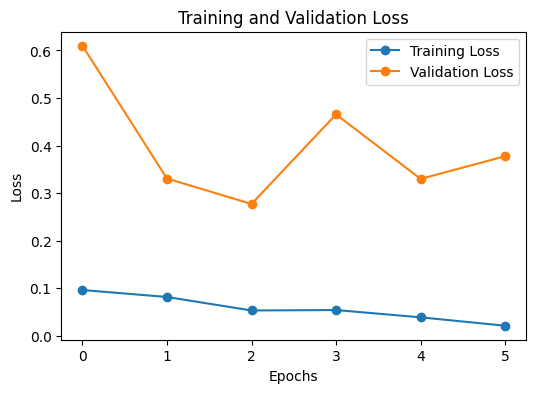

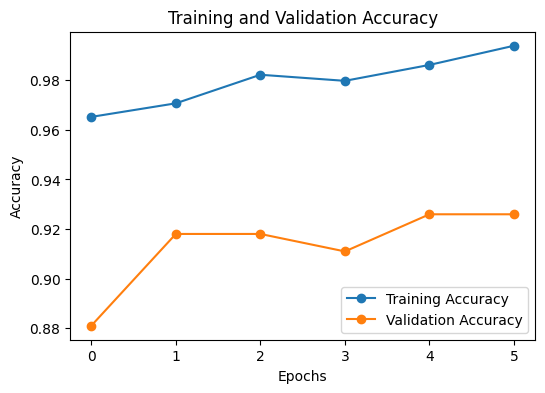

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




36/36 [==============================] - 1s 31ms/step - loss: 0.2109 - accuracy: 0.9321
Test Loss: 0.21088434755802155
Test Accuracy: 0.9320987462997437
36/36 [==============================] - 2s 26ms/step
Precision: 0.9328669314019599
Recall: 0.9320987654320988
F1-score: 0.9323790415246535


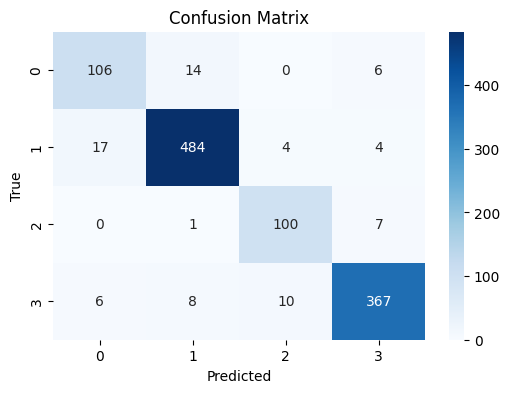

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Y_pred = model.predict(X_test)
Y_pred_classes_resnet = np.argmax(Y_pred, axis=1)


Y_test_classes = np.argmax(Y_test, axis=1)


precision = precision_score(Y_test_classes, Y_pred_classes_resnet, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes_resnet, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes_resnet, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_resnet)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**EfficientNet**

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:





history = model.fit(X_train, Y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/10
166/166 [==============================] - 60s 121ms/step - loss: 0.5330 - accuracy: 0.8133 - val_loss: 0.3210 - val_accuracy: 0.8880
Epoch 2/10
166/166 [==============================] - 13s 80ms/step - loss: 0.1844 - accuracy: 0.9390 - val_loss: 0.1492 - val_accuracy: 0.9453
Epoch 3/10
166/166 [==============================] - 13s 81ms/step - loss: 0.0948 - accuracy: 0.9718 - val_loss: 0.1220 - val_accuracy: 0.9594
Epoch 4/10
166/166 [==============================] - 13s 81ms/step - loss: 0.0555 - accuracy: 0.9843 - val_loss: 0.1058 - val_accuracy: 0.9674
Epoch 5/10
166/166 [==============================] - 13s 80ms/step - loss: 0.0375 - accuracy: 0.9894 - val_loss: 0.1131 - val_accuracy: 0.9594
Epoch 6/10
166/166 [==============================] - 13s 81ms/step - loss: 0.0290 - accuracy: 0.9928 - val_loss: 0.0801 - val_accuracy: 0.9727
Epoch 7/10
166/166 [==============================] - 13s 80ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0806 - val_accuracy

In [ ]:
for layer in base_model.layers[:20]:
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/20
166/166 [==============================] - 50s 92ms/step - loss: 0.0204 - accuracy: 0.9951 - val_loss: 0.0823 - val_accuracy: 0.9735
Epoch 2/20
166/166 [==============================] - 13s 80ms/step - loss: 0.0190 - accuracy: 0.9962 - val_loss: 0.0824 - val_accuracy: 0.9735
Epoch 3/20
166/166 [==============================] - 13s 81ms/step - loss: 0.0200 - accuracy: 0.9958 - val_loss: 0.0821 - val_accuracy: 0.9744
Epoch 4/20
166/166 [==============================] - 13s 81ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.0815 - val_accuracy: 0.9735
Epoch 5/20
166/166 [==============================] - 13s 80ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0813 - val_accuracy: 0.9744
Epoch 6/20
166/166 [==============================] - 14s 81ms/step - loss: 0.0209 - accuracy: 0.9949 - val_loss: 0.0808 - val_accuracy: 0.9735
Epoch 7/20
166/166 [==============================] - 13s 81ms/step - loss: 0.0163 - accuracy: 0.9968 - val_loss: 0.0809 - val_accuracy:

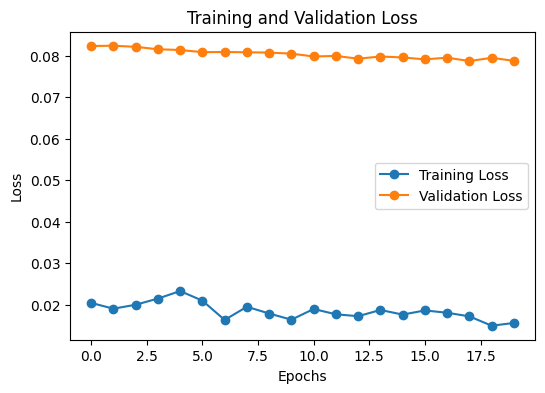

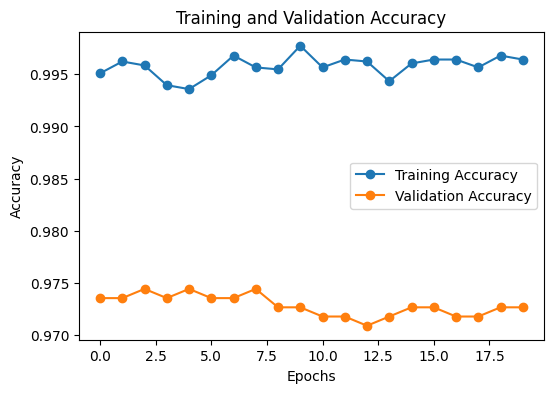

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




36/36 [==============================] - 1s 21ms/step - loss: 0.0830 - accuracy: 0.9718
Test Loss: 0.08302345126867294
Test Accuracy: 0.971781313419342
36/36 [==============================] - 2s 17ms/step
Precision: 0.9719761052956296
Recall: 0.9717813051146384
F1-score: 0.9718436787066086


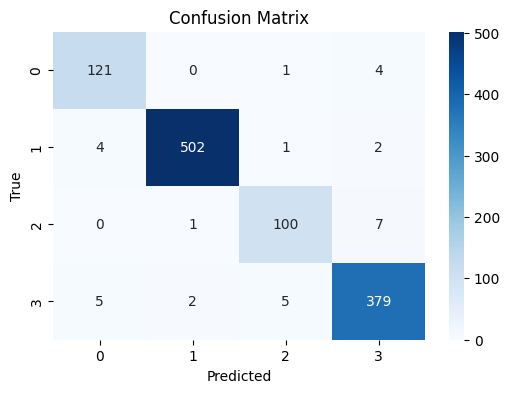

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Y_pred = model.predict(X_test)
Y_pred_classes_efficient = np.argmax(Y_pred, axis=1)


Y_test_classes = np.argmax(Y_test, axis=1)


precision = precision_score(Y_test_classes, Y_pred_classes_efficient, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes_efficient, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes_efficient, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_efficient)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**VGG**

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

num_classes = 4


predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:



history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, Y_val), callbacks=[early_stopping])

Epoch 1/20
166/166 [==============================] - 33s 140ms/step - loss: 0.6673 - accuracy: 0.7876 - val_loss: 0.3498 - val_accuracy: 0.8757
Epoch 2/20
166/166 [==============================] - 19s 114ms/step - loss: 0.2935 - accuracy: 0.8936 - val_loss: 0.2926 - val_accuracy: 0.8765
Epoch 3/20
166/166 [==============================] - 19s 115ms/step - loss: 0.2038 - accuracy: 0.9263 - val_loss: 0.2870 - val_accuracy: 0.8871
Epoch 4/20
166/166 [==============================] - 19s 115ms/step - loss: 0.1269 - accuracy: 0.9562 - val_loss: 0.1776 - val_accuracy: 0.9480
Epoch 5/20
166/166 [==============================] - 19s 114ms/step - loss: 0.1023 - accuracy: 0.9643 - val_loss: 0.2115 - val_accuracy: 0.9250
Epoch 6/20
166/166 [==============================] - 19s 117ms/step - loss: 0.0702 - accuracy: 0.9752 - val_loss: 0.1593 - val_accuracy: 0.9489
Epoch 7/20
166/166 [==============================] - 20s 121ms/step - loss: 0.0676 - accuracy: 0.9773 - val_loss: 0.1052 - val_ac

In [ ]:
for layer in base_model.layers[:20]:
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=25, batch_size=32,
                    validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/25
166/166 [==============================] - 23s 115ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.1076 - val_accuracy: 0.9700
Epoch 2/25
166/166 [==============================] - 19s 115ms/step - loss: 0.0130 - accuracy: 0.9975 - val_loss: 0.1044 - val_accuracy: 0.9683
Epoch 3/25
166/166 [==============================] - 19s 112ms/step - loss: 0.0098 - accuracy: 0.9979 - val_loss: 0.1038 - val_accuracy: 0.9709
Epoch 4/25
166/166 [==============================] - 18s 111ms/step - loss: 0.0076 - accuracy: 0.9991 - val_loss: 0.1052 - val_accuracy: 0.9691
Epoch 5/25
166/166 [==============================] - 19s 112ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.1051 - val_accuracy: 0.9727
Epoch 6/25
166/166 [==============================] - 19s 113ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.1033 - val_accuracy: 0.9753
Epoch 7/25
166/166 [==============================] - 19s 112ms/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 0.1065 - val_ac

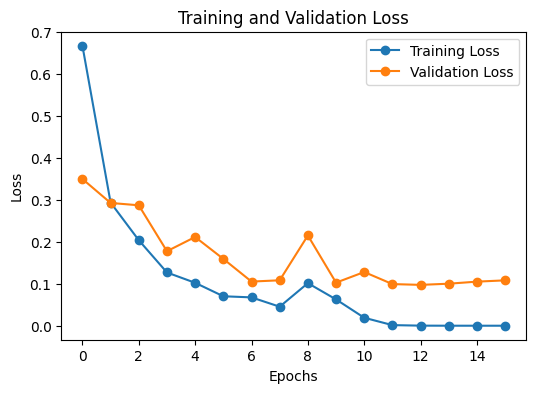

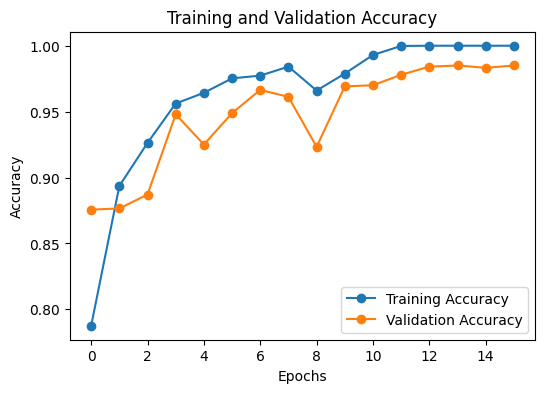

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




36/36 [==============================] - 1s 34ms/step - loss: 0.1017 - accuracy: 0.9780
Test Loss: 0.10172679275274277
Test Accuracy: 0.9779541492462158
36/36 [==============================] - 1s 31ms/step
Precision: 0.9778779515643361
Recall: 0.9779541446208113
F1-score: 0.9778390644146917


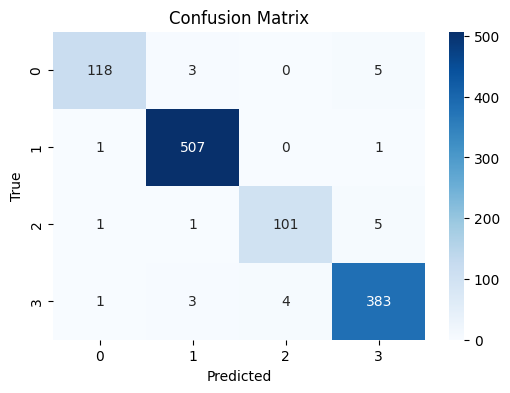

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Y_pred = model.predict(X_test)
Y_pred_classes_vgg = np.argmax(Y_pred, axis=1)


Y_test_classes = np.argmax(Y_test, axis=1)


precision = precision_score(Y_test_classes, Y_pred_classes_vgg, average='weighted')
recall = recall_score(Y_test_classes, Y_pred_classes_vgg, average='weighted')
f1 = f1_score(Y_test_classes, Y_pred_classes_vgg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_vgg)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Ensambling**

In [ ]:

ensemble_predictions = np.vstack([Y_pred_classes_dense,
                                  Y_pred_classes_custom,
                                  Y_pred_classes_resnet,
                                  Y_pred_classes_efficient,
                                  Y_pred_classes_vgg])


final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=ensemble_predictions)



Test Accuracy: 0.9805996472663139
Precision: 0.9805220327080533
Recall: 0.9805996472663139
F1-score: 0.980535544361422


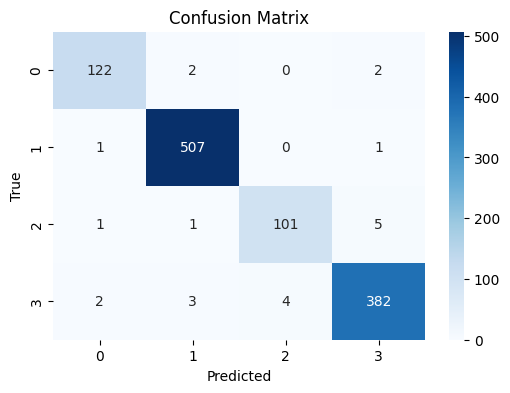

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


Y_test_classes = np.argmax(Y_test, axis=1)
from sklearn.metrics import accuracy_score




test_accuracy = accuracy_score(Y_test_classes, final_predictions)
print("Test Accuracy:", test_accuracy)



precision = precision_score(Y_test_classes, final_predictions, average='weighted')
recall = recall_score(Y_test_classes, final_predictions, average='weighted')
f1 = f1_score(Y_test_classes, final_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, final_predictions)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
ensemble_predictions.shape

(5, 1134)

In [ ]:
print("Shape of final_predictions:", final_predictions.shape)


Shape of final_predictions: (1134,)


In [ ]:
import numpy as np



final_predictions_avg = (Y_pred_classes_dense +
                       Y_pred_classes_custom +
                       Y_pred_classes_resnet +
                       Y_pred_classes_efficient +
                       Y_pred_classes_vgg) / 5  # Dividing by the number of models




In [ ]:
from sklearn.metrics import accuracy_score


rounded_predictions_avg= np.round(final_predictions_avg).astype(int)


accuracy = accuracy_score(Y_test_classes, rounded_predictions_avg)
print("Accuracy:", accuracy)


Accuracy: 0.9497354497354498


Precision: 0.9526979180892577
Recall: 0.9497354497354498
F1-score: 0.9493096701393872


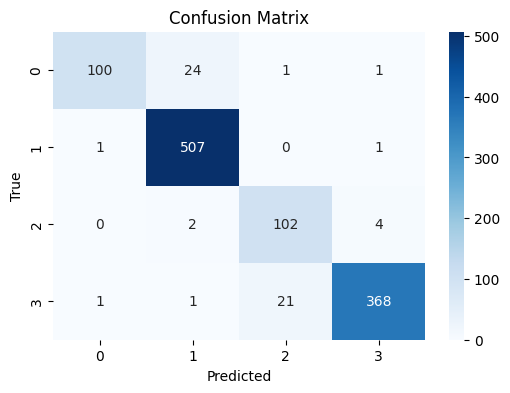

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


Y_test_classes = np.argmax(Y_test, axis=1)
from sklearn.metrics import accuracy_score








precision = precision_score(Y_test_classes, rounded_predictions_avg, average='weighted')
recall = recall_score(Y_test_classes, rounded_predictions_avg, average='weighted')
f1 = f1_score(Y_test_classes, rounded_predictions_avg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, rounded_predictions_avg)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np



weights = {
    'dense': 0.05,
    'custom': 0.01,
    'resnet': 0.04,
    'efficient': 0.4,
    'vgg': 0.5
}


final_predictions_weight = (weights['dense'] * Y_pred_classes_dense +
                      weights['custom'] * Y_pred_classes_custom +
                      weights['resnet'] * Y_pred_classes_resnet +
                      weights['efficient'] * Y_pred_classes_efficient +
                      weights['vgg'] * Y_pred_classes_vgg)




In [ ]:
from sklearn.metrics import accuracy_score


rounded_predictions_weight = np.round(final_predictions_weight).astype(int)


accuracy = accuracy_score(Y_test_classes, rounded_predictions_weight)
print("Accuracy:", accuracy)


Accuracy: 0.9708994708994709


Precision: 0.9717232656563597
Recall: 0.9708994708994709
F1-score: 0.9710268498590396


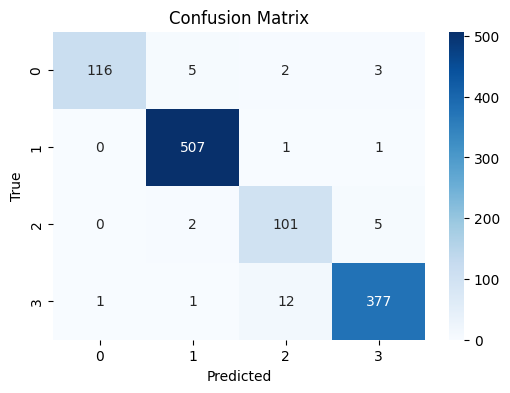

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


Y_test_classes = np.argmax(Y_test, axis=1)
from sklearn.metrics import accuracy_score




#test_accuracy = accuracy_score(Y_test_classes, final_predictions_weight)
#print("Test Accuracy:", test_accuracy)



precision = precision_score(Y_test_classes, rounded_predictions_weight, average='weighted')
recall = recall_score(Y_test_classes, rounded_predictions_weight, average='weighted')
f1 = f1_score(Y_test_classes, rounded_predictions_weight, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


conf_matrix = confusion_matrix(Y_test_classes, rounded_predictions_weight)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Comparison of Test Accuracy among Models')

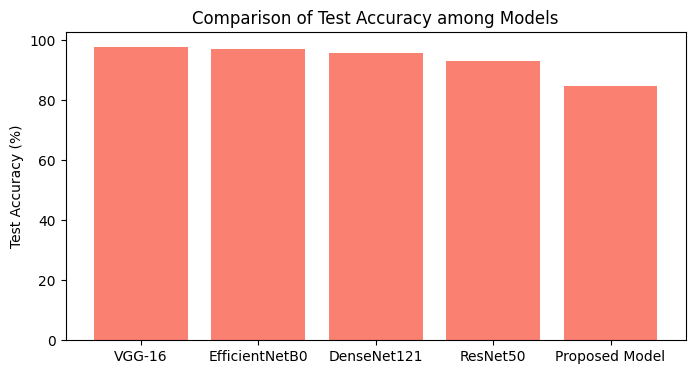

In [ ]:
import matplotlib.pyplot as plt


models = ['VGG-16', 'EfficientNetB0', 'DenseNet121', 'ResNet50', 'Proposed Model']


training_accuracy = [100.0, 99.57, 99.17, 98.62, 95.07]


training_loss = [2.3777e-05, 0.0170, 0.013, 0.0391, 0.1675]


test_accuracy = [97.79, 97.17, 95.8, 93.20, 84.92]


test_loss = [0.1017, 0.0830, 0.16, 0.2108, 0.5046]


plt.figure(figsize=(8, 4))



plt.bar(models, test_accuracy, color='salmon')
plt.ylabel('Test Accuracy (%)')
plt.title('Comparison of Test Accuracy among Models')






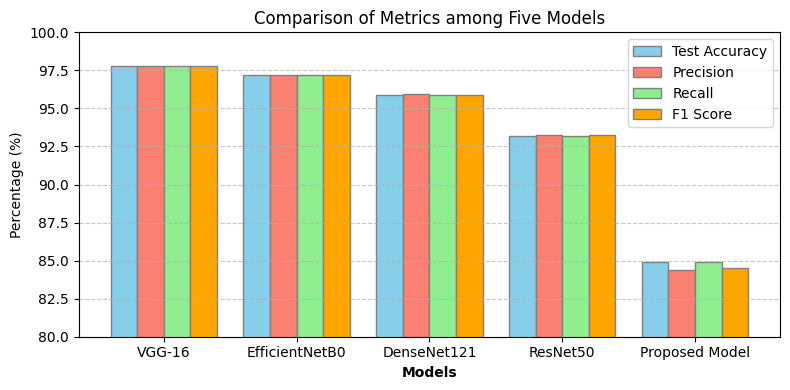

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


models = ['VGG-16', 'EfficientNetB0', 'DenseNet121', 'ResNet50', 'Proposed Model']


test_accuracy = [97.79, 97.17, 95.85, 93.20, 84.92]


precision = [97.78, 97.19, 95.93, 93.28, 84.36]


recall = [97.79, 97.17, 95.85, 93.20, 84.92]


f1_score = [97.78, 97.18, 95.87, 93.23, 84.53]


bar_width = 0.2


r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting
plt.figure(figsize=(8, 4))

plt.bar(r1, test_accuracy, color='skyblue', width=bar_width, edgecolor='grey', label='Test Accuracy')
plt.bar(r2, precision, color='salmon', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='lightgreen', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_score, color='orange', width=bar_width, edgecolor='grey', label='F1 Score')


plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(models))], models)


plt.legend()
plt.title('Comparison of Metrics among Five Models')
plt.ylabel('Percentage (%)')
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


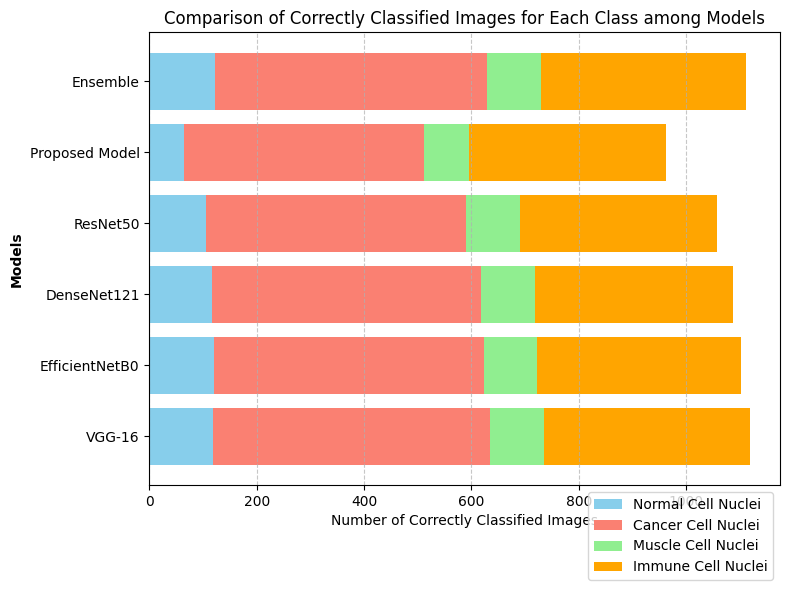

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


models = ['VGG-16', 'EfficientNetB0', 'DenseNet121', 'ResNet50', 'Proposed Model', 'Ensemble']


label_0 = [118, 121, 117, 106, 65, 122]
label_1 = [517, 502, 500, 484, 447, 507]
label_2 = [101, 100, 101, 100, 83, 101]
label_3 = [383, 379, 369, 367, 368, 382]


y_pos = np.arange(len(models))


plt.figure(figsize=(8, 6))

plt.barh(y_pos, label_0, color='skyblue', label='Normal Cell Nuclei')
plt.barh(y_pos, label_1, color='salmon', left=label_0, label='Cancer Cell Nuclei')
plt.barh(y_pos, label_2, color='lightgreen', left=np.add(label_0, label_1), label='Muscle Cell Nuclei')
plt.barh(y_pos, label_3, color='orange', left=np.add(np.add(label_0, label_1), label_2), label='Immune Cell Nuclei')


plt.yticks(y_pos, models)
plt.ylabel('Models', fontweight='bold')


plt.legend(loc='upper right', bbox_to_anchor=(1, 0))
plt.title('Comparison of Correctly Classified Images for Each Class among Models')
plt.xlabel('Number of Correctly Classified Images')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


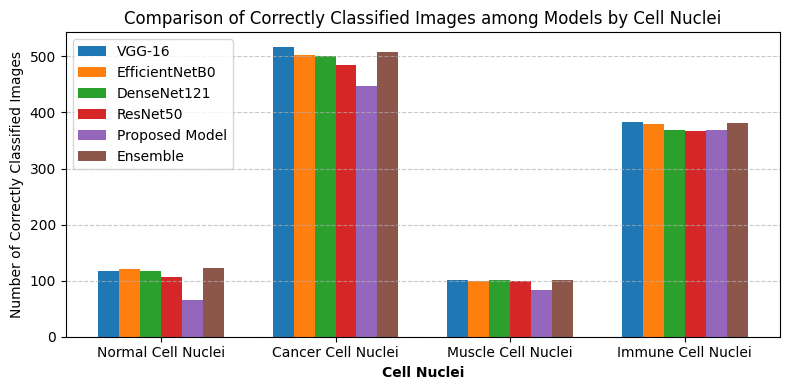

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


models = ['VGG-16', 'EfficientNetB0', 'DenseNet121', 'ResNet50', 'Proposed Model', 'Ensemble']


labels = ['Normal Cell Nuclei', 'Cancer Cell Nuclei', 'Muscle Cell Nuclei', 'Immune Cell Nuclei']


correct_images = {
    'VGG-16': [118, 517, 101, 383],
    'EfficientNetB0': [121, 502, 100, 379],
    'DenseNet121': [117, 500, 101, 369],
    'ResNet50': [106, 484, 100, 367],
    'Proposed Model': [65, 447, 83, 368],
    'Ensemble': [122, 507, 101, 382]
}


bar_width = 0.12
index = np.arange(len(labels))


plt.figure(figsize=(8, 4))

for i, model in enumerate(models):
    plt.bar(index + (bar_width * i), correct_images[model], bar_width, label=model)


plt.xlabel('Cell Nuclei', fontweight='bold')
plt.ylabel('Number of Correctly Classified Images')
plt.xticks(index + (bar_width * (len(models) - 1) / 2), labels)
plt.title('Comparison of Correctly Classified Images among Models by Cell Nuclei')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
